Project Proposal: Telco Customer Churn Prediction & Retention Strategy

The goal is to build a predictive model that identifies customers at high risk of churning and provides actionable insights for retention programs.
1. Project Lifecycle & Key Steps

Step 1: Data Preprocessing & Cleaning

    Handle Missing Values: TotalCharges has 11 empty strings (' ') that need to be converted to numeric values (setting them to 0 or tenure × monthly charges).

    Encoding Categorical Variables: Convert binary columns (e.g., gender, Partner, Churn) to 0/1 and apply One-Hot Encoding to multi-category columns like Contract and PaymentMethod.

    Feature Scaling: Normalize numerical features like tenure and MonthlyCharges for models like Logistic Regression.

Step 2: Exploratory Data Analysis (EDA)

    Demographics: Are senior citizens more likely to churn? Do partners/dependents provide stability?

    Services: Which internet service (DSL vs. Fiber optic) has the highest churn? Does "TechSupport" reduce churn?

    Account Info: Analyze how contract types (Month-to-month vs. Two-year) affect retention.

Step 3: Predictive Modeling

    Baseline Model: Start with Logistic Regression for interpretability.  

    Advanced Model: Use Random Forest or XGBoost to capture non-linear relationships.  

    Handling Imbalance: Since churners are only ~26.5% of the data, use techniques like SMOTE (Synthetic Minority Over-sampling Technique) to balance the classes.  

Step 4: Model Evaluation

    Focus on Recall (how many actual churners did we catch?) and ROC-AUC rather than just Accuracy.

    Feature Importance: Identify which features (e.g., tenure, contract type) most strongly predict churn.

Initial Data Insights

Based on the preliminary analysis, here are some key observations from the dataset:

    Overall Churn Rate: 26.54% of customers have churned.

    Contract Type: Customers on Month-to-month contracts have a significantly higher churn rate compared to those on one or two-year contracts.

    Tenure: Most churn happens in the first few months of service (new customers are high risk).

    Monthly Charges: Higher monthly charges correlate with a higher probability of churning.

Next Steps for Your Project

    Feature Engineering: Create a new feature like AvgChargePerMonth or TenureGroup (e.g., 0-12 months, 12-24 months).

    Hyperparameter Tuning: Use GridSearchCV to optimize your model parameters.

    Visualization: Build a dashboard or use SHAP (Shapley Additive Explanations) to visualize why specific customers are predicted to churn.

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Load and clean
df = pd.read_csv('Telco_Customer_Churn.csv')

# View data
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [47]:
print(df.shape)

(7043, 21)


In [48]:
#  1: Data Preprocessing & Cleaning

# Check for missing values
print(df.isna().sum())

# Check details of data
print(df.info())

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   obj

In [49]:
# Check for blank rows
total_blanks = (df.astype(str).apply(lambda col: col.str.strip() == "")).sum().sum()
print(total_blanks)

# Convert blanks to Nan
df_clean = df.replace(r'^\s*$', np.nan, regex=True)
print(df_clean.isna().sum())

11
customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


In [50]:
# Replace blanks in Total Charges with 0
df_clean['TotalCharges'] = pd.to_numeric(df_clean['TotalCharges']).fillna(0)
print(df_clean['TotalCharges'].isna().sum())

# Detect binary and multi-category for categorical columns
categorical_cols = df_clean.select_dtypes(include=["object", "category"]).columns

unique_counts = df_clean[categorical_cols].nunique(dropna=False)

binary_cols = unique_counts[unique_counts == 2].index.tolist()
multi_category_cols = unique_counts[unique_counts > 2].index.tolist()

print("Binary:", binary_cols)
print("Multi-category:", multi_category_cols)

0
Binary: ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
Multi-category: ['customerID', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']


In [51]:
# Encode Categorical Variables
# For binary columns
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']

for col in binary_cols:
    df_clean[col] = df_clean[col].map({'Yes': 1, 'No': 0})

# Encode gender
df_clean['gender'] = df_clean['gender'].map({'Male': 1, 'Female': 0})

# For multi-category columns
# Handle 'No internet service'
col_fix = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

for col in col_fix:
    df_clean[col] = df_clean[col].replace('No internet service', 'No')


# Drop Customer ID
df_clean = df_clean.drop('customerID', axis=1)

# Define multi-category columns
multi_cols = [
    'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 
    'Contract', 'PaymentMethod'
]

# Apply One-Hot encoding
df_final = pd.get_dummies(df_clean, columns=multi_cols, drop_first=True)

# View the result
df_final.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,29.85,29.85,0,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False
1,1,0,0,0,34,1,0,56.95,1889.50,0,False,False,False,False,True,False,True,False,False,False,True,False,False,False,True
2,1,0,0,0,2,1,1,53.85,108.15,1,False,False,False,False,True,True,False,False,False,False,False,False,False,False,True
3,1,0,0,0,45,0,0,42.30,1840.75,0,True,False,False,False,True,False,True,True,False,False,True,False,False,False,False
4,0,0,0,0,2,1,1,70.70,151.65,1,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False


In [52]:
# Feature Engineering

# Add Average Charge per month
df_final['AvgChargePerMonth'] = df_final['MonthlyCharges'] / df['tenure'].replace(0, 1)

df_final.head(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,AvgChargePerMonth
0,0,0,1,0,1,0,1,29.85,29.85,0,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False,29.850
1,1,0,0,0,34,1,0,56.95,1889.50,0,False,False,False,False,True,False,True,False,False,False,True,False,False,False,True,1.675
2,1,0,0,0,2,1,1,53.85,108.15,1,False,False,False,False,True,True,False,False,False,False,False,False,False,False,True,26.925
3,1,0,0,0,45,0,0,42.30,1840.75,0,True,False,False,False,True,False,True,True,False,False,True,False,False,False,False,0.940
4,0,0,0,0,2,1,1,70.70,151.65,1,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,35.350


In [53]:
# 2. Exploratory Data Analysis
# Get summary stats of numerical columns
numerical_summary = df_final[['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Churn', 'AvgChargePerMonth']].describe()
numerical_summary



,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,AvgChargePerMonth
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2279.734304,0.265370,8.671312
std,0.368612,24.559481,30.090047,2266.794470,0.441561,16.415124
min,0.000000,0.000000,18.250000,0.000000,0.000000,0.268056
25%,0.000000,9.000000,35.500000,398.550000,0.000000,1.278093
50%,0.000000,29.000000,70.350000,1394.550000,0.000000,2.150000
75%,0.000000,55.000000,89.850000,3786.600000,1.000000,6.641190
max,1.000000,72.000000,118.750000,8684.800000,1.000000,102.450000


Churn Count:
Churn
No     5174
Yes    1869
Name: count, dtype: int64

Churn Percentage:
Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64


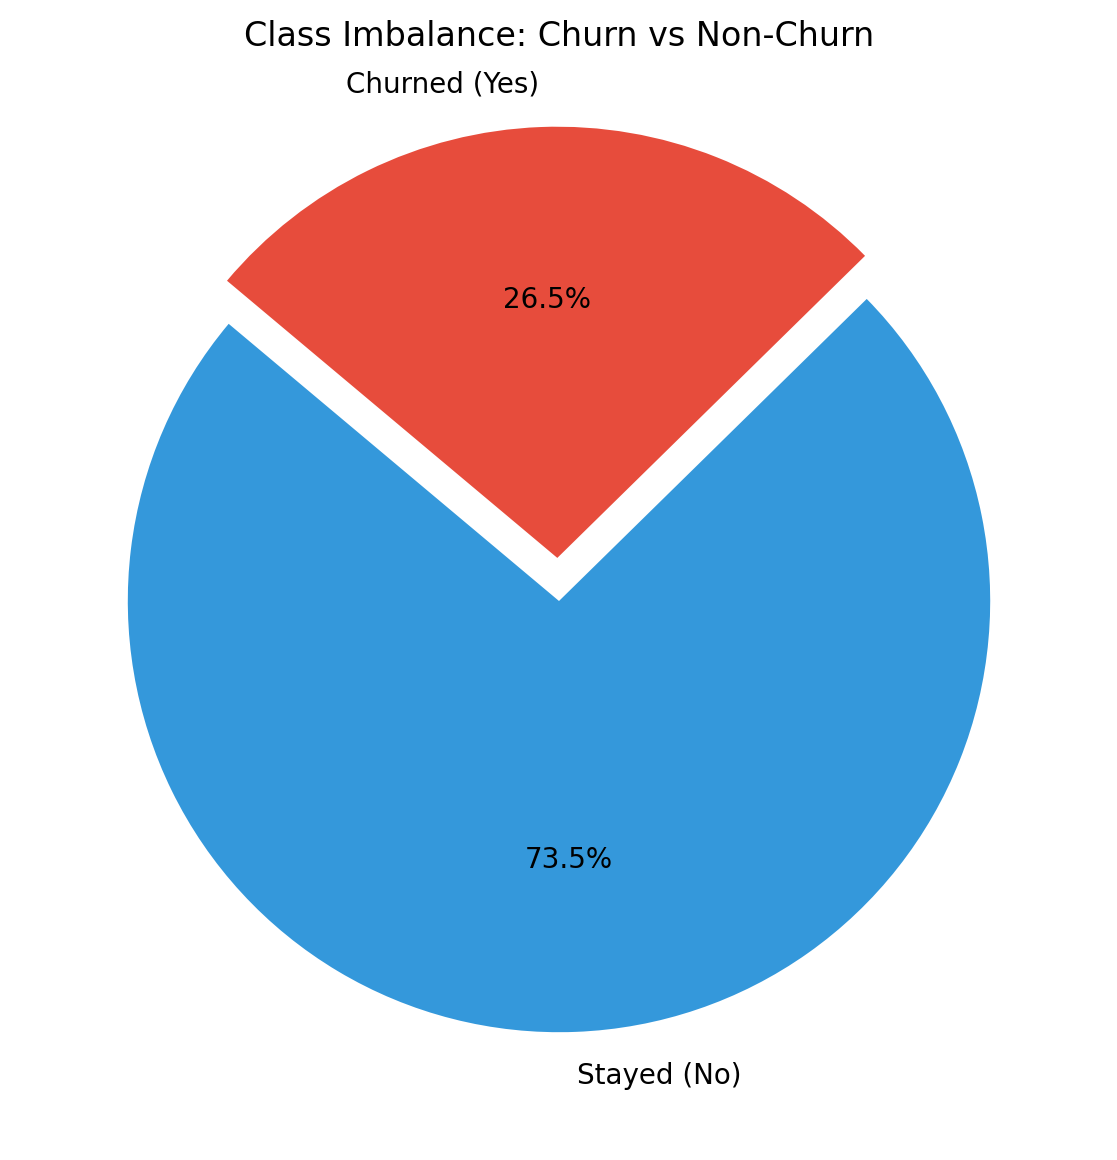

In [54]:
# Calculate Counts and Percentages 
churn_counts = df['Churn'].value_counts()
churn_pct = df['Churn'].value_counts(normalize=True) * 100

print(f"Churn Count:\n{churn_counts}")
print(f"\nChurn Percentage:\n{churn_pct}")

# Visualize in a Pie Chart
plt.figure(figsize=(7, 7))
plt.pie(churn_counts,
       labels=['Stayed (No)', 'Churned (Yes)'],
       autopct='%1.1f%%',
       startangle=140,
        colors=['#3498db', '#e74c3c'],
        explode=(0, 0.1))
plt.title('Class Imbalance: Churn vs Non-Churn')
plt.show()

Data is imbalanced. In churn prediction, because a few customers churn, a model can become biased toward predicting “no churn” and fail to correctly identify customers who are at risk of leaving.

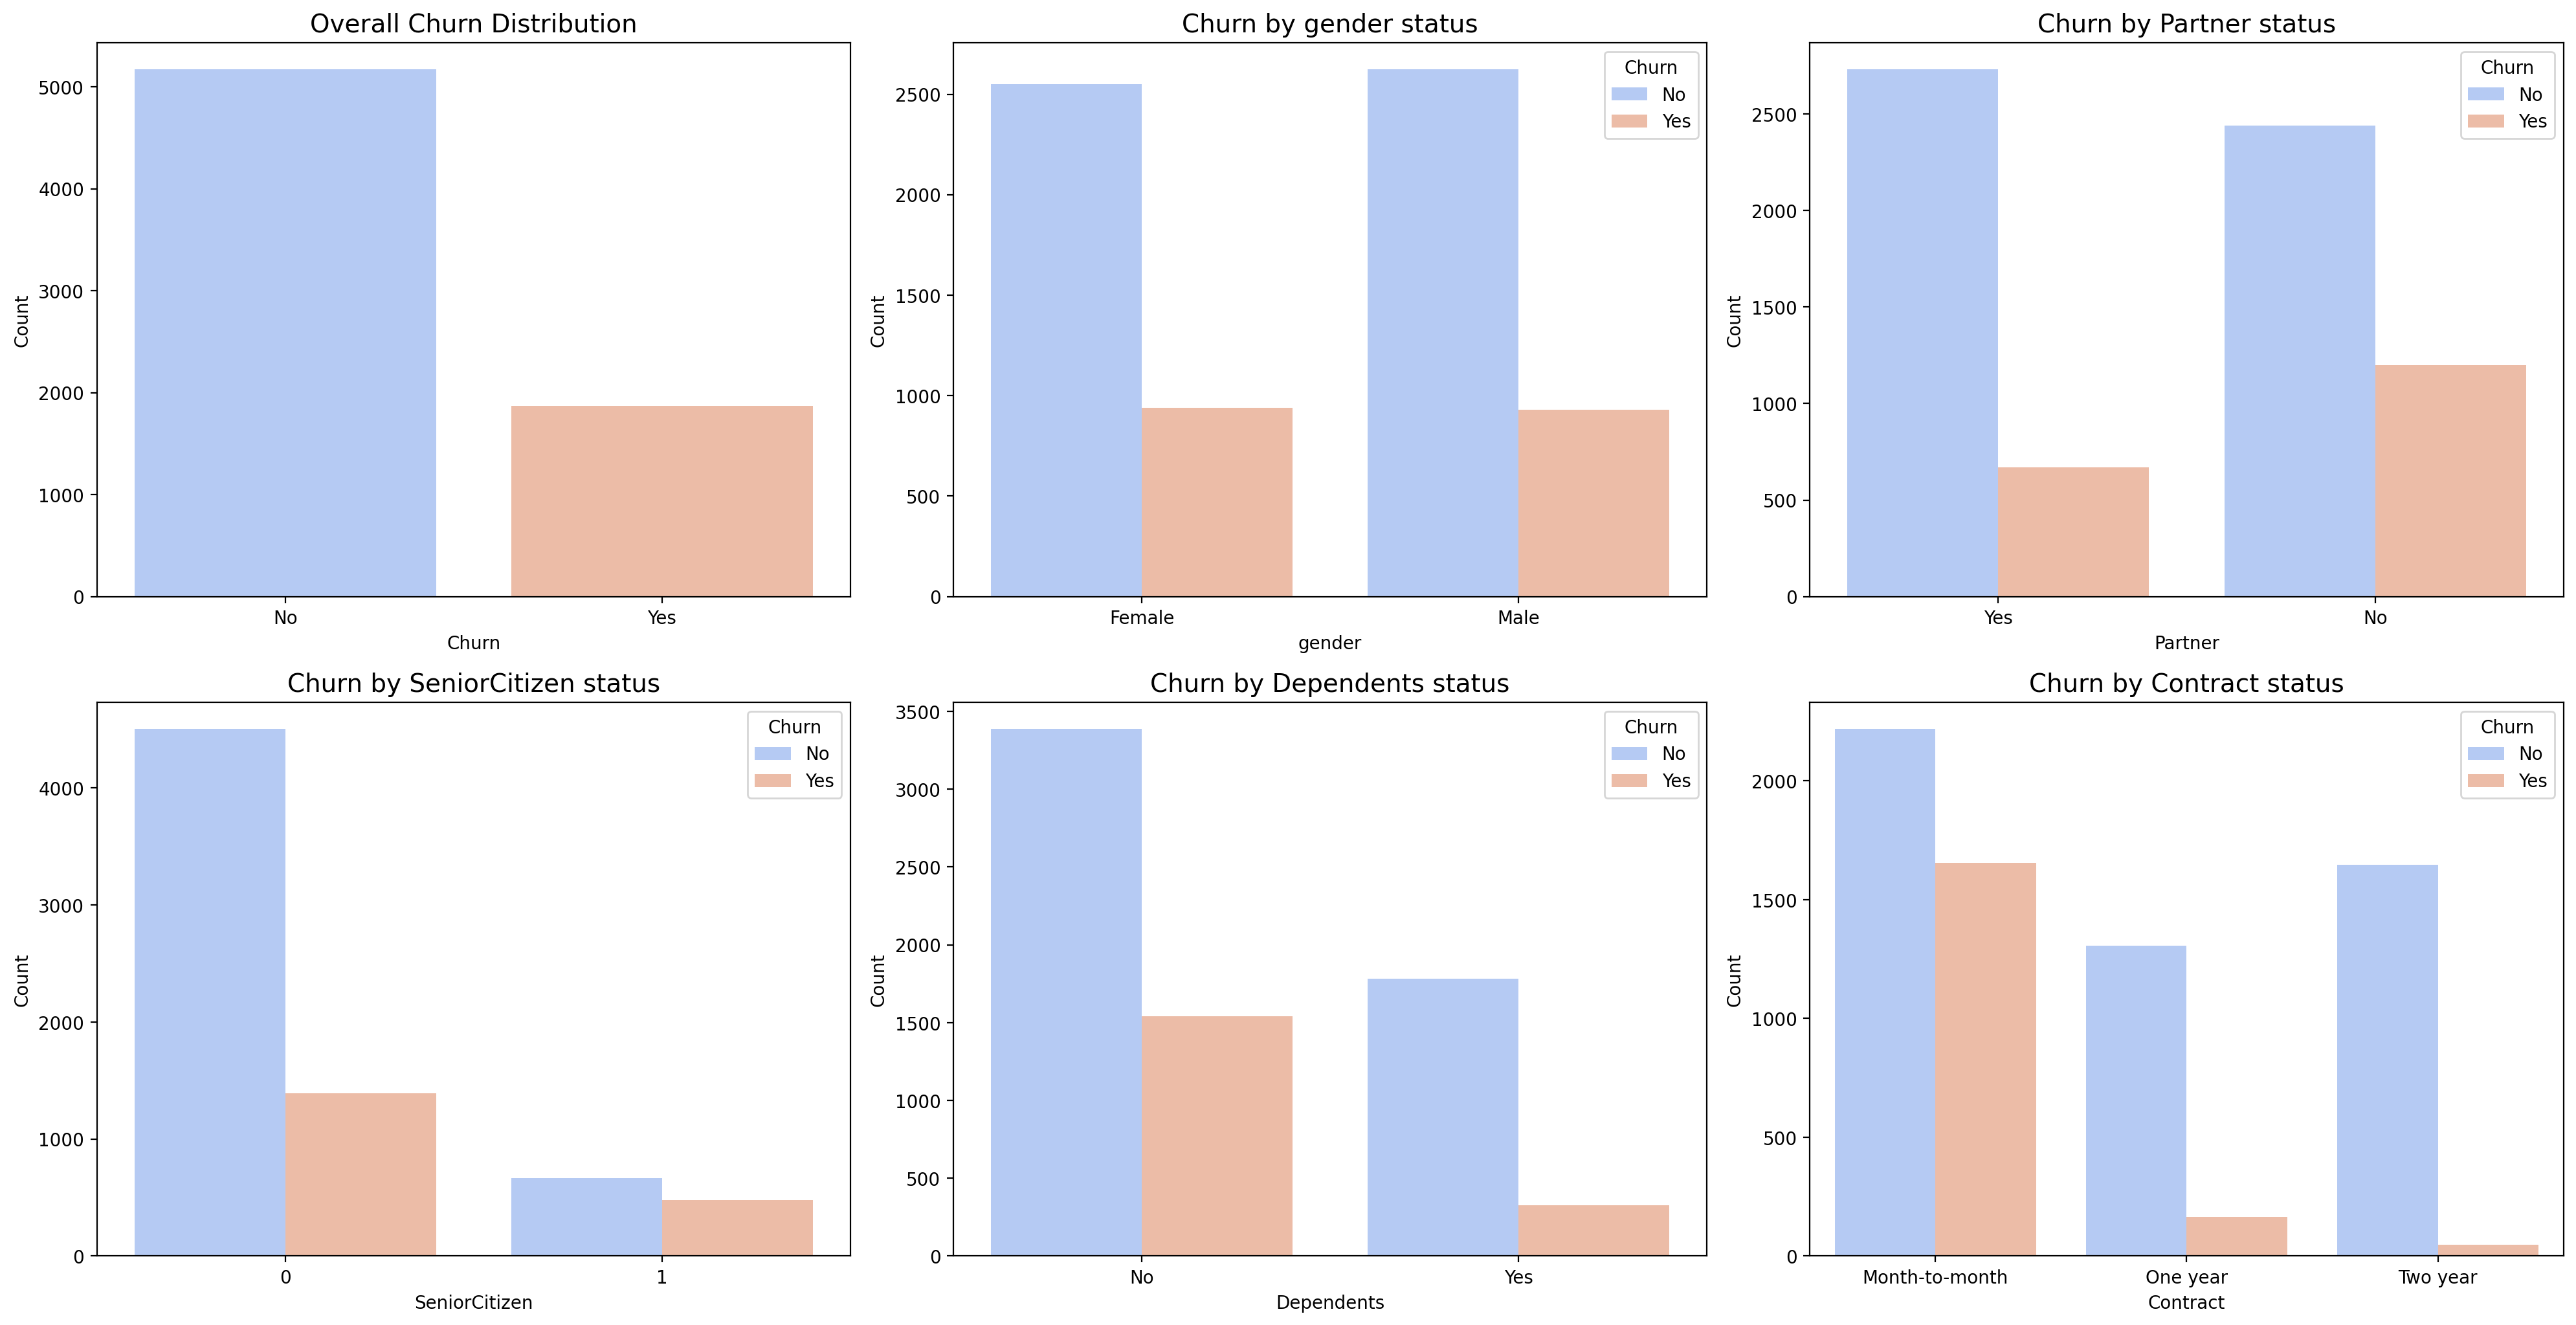

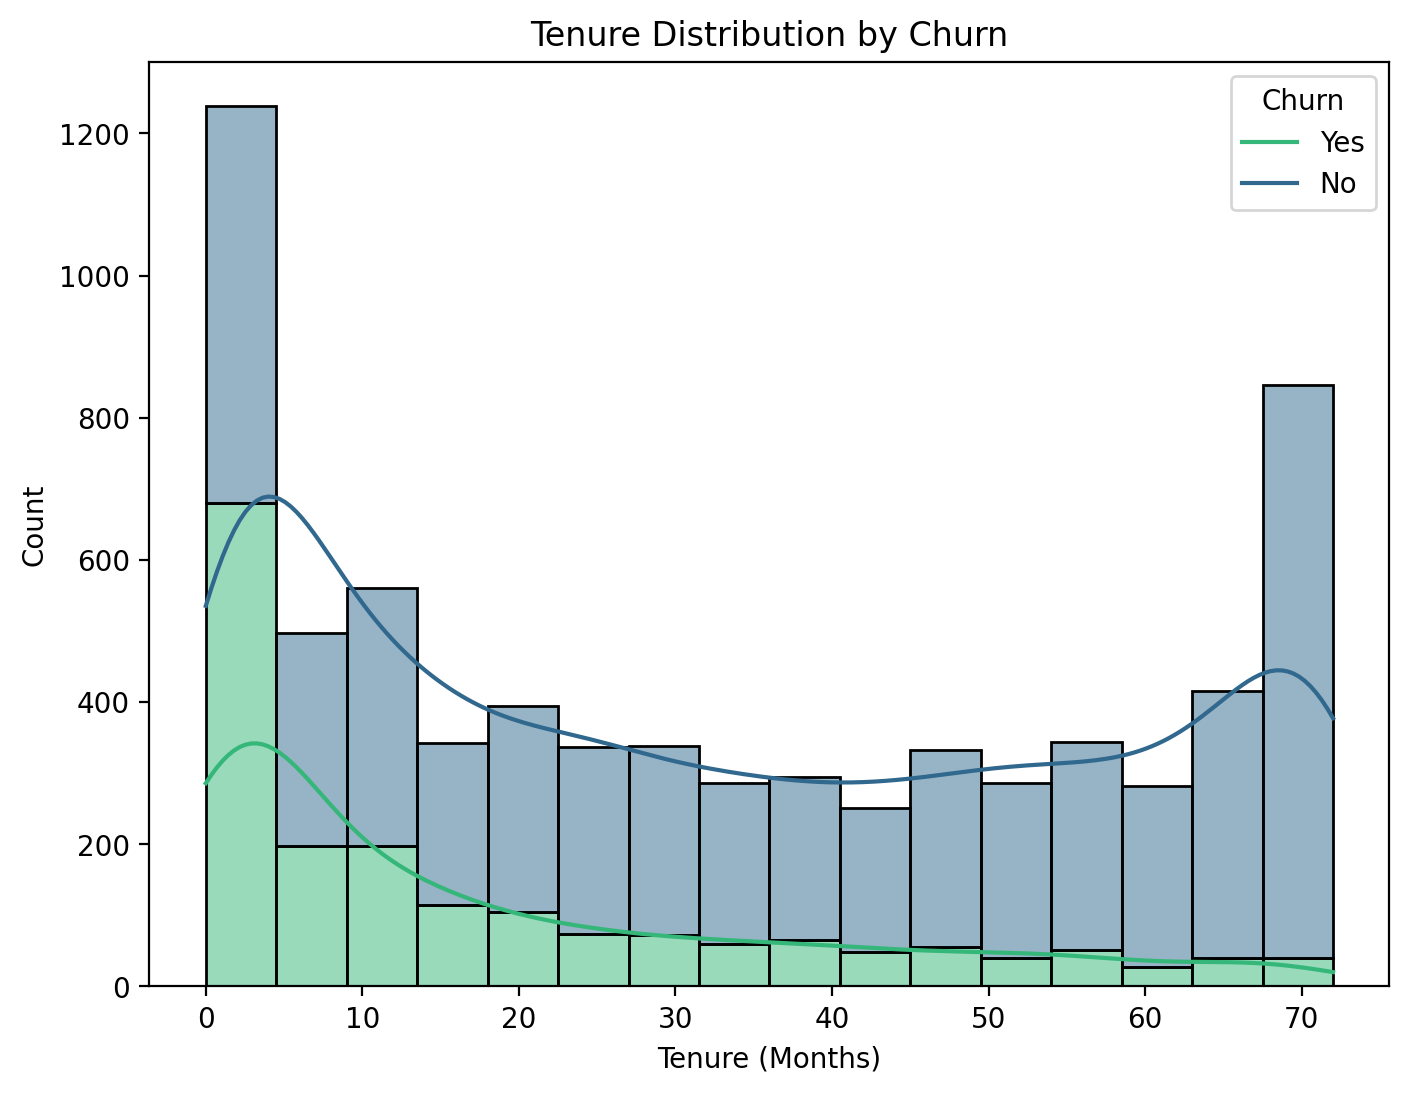

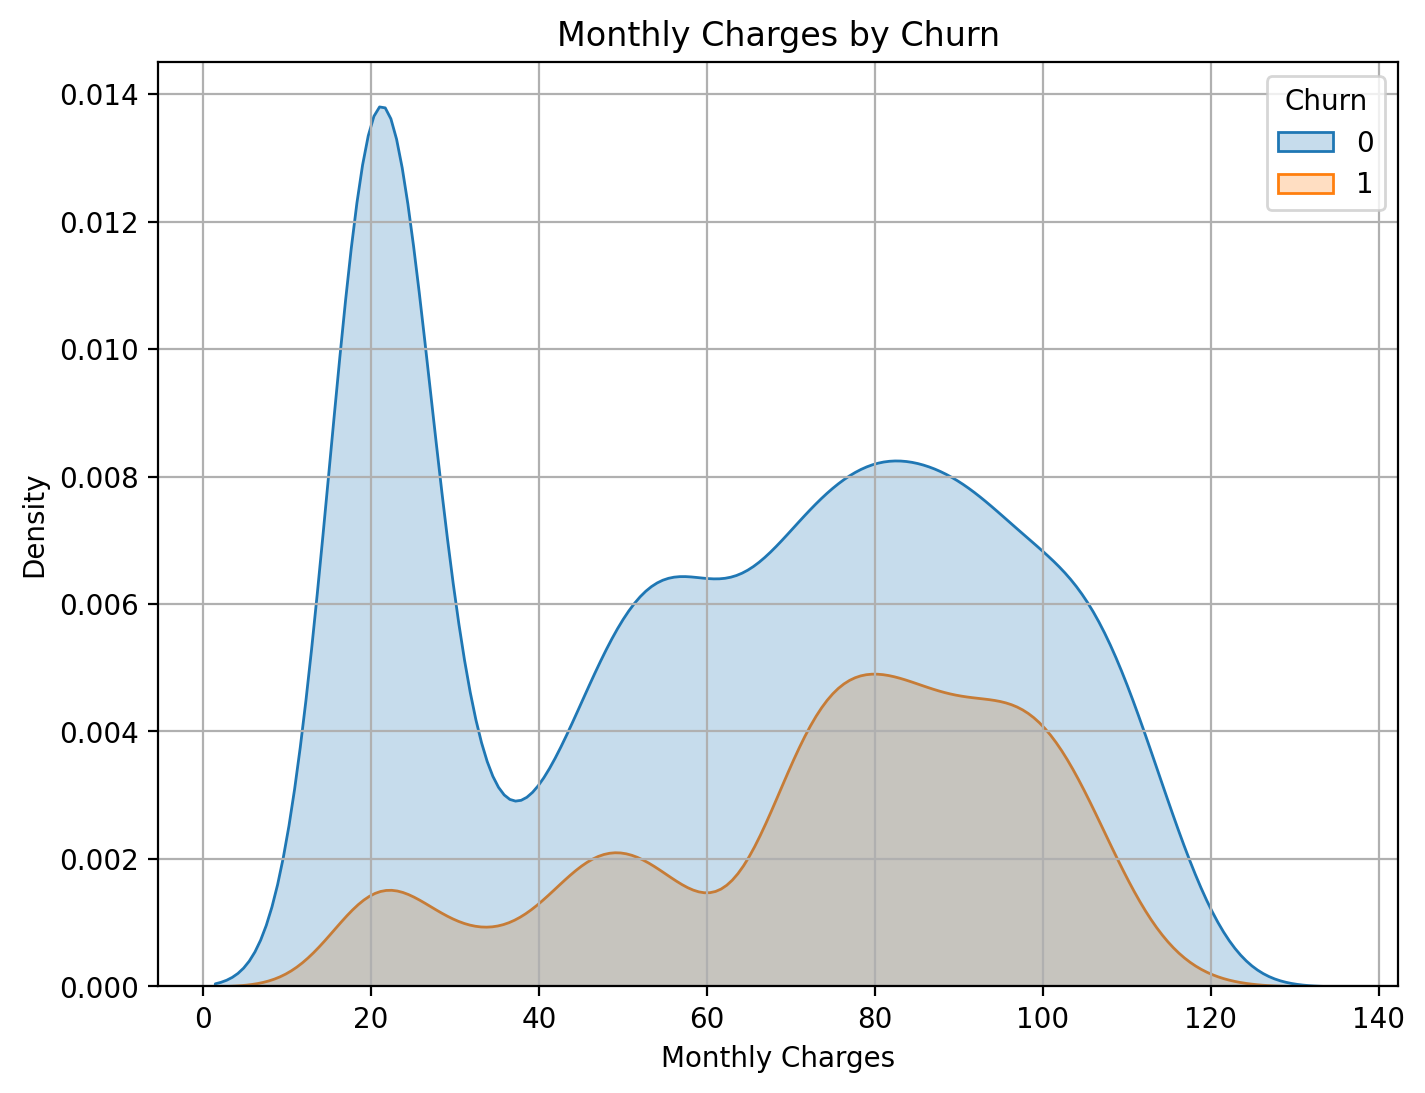

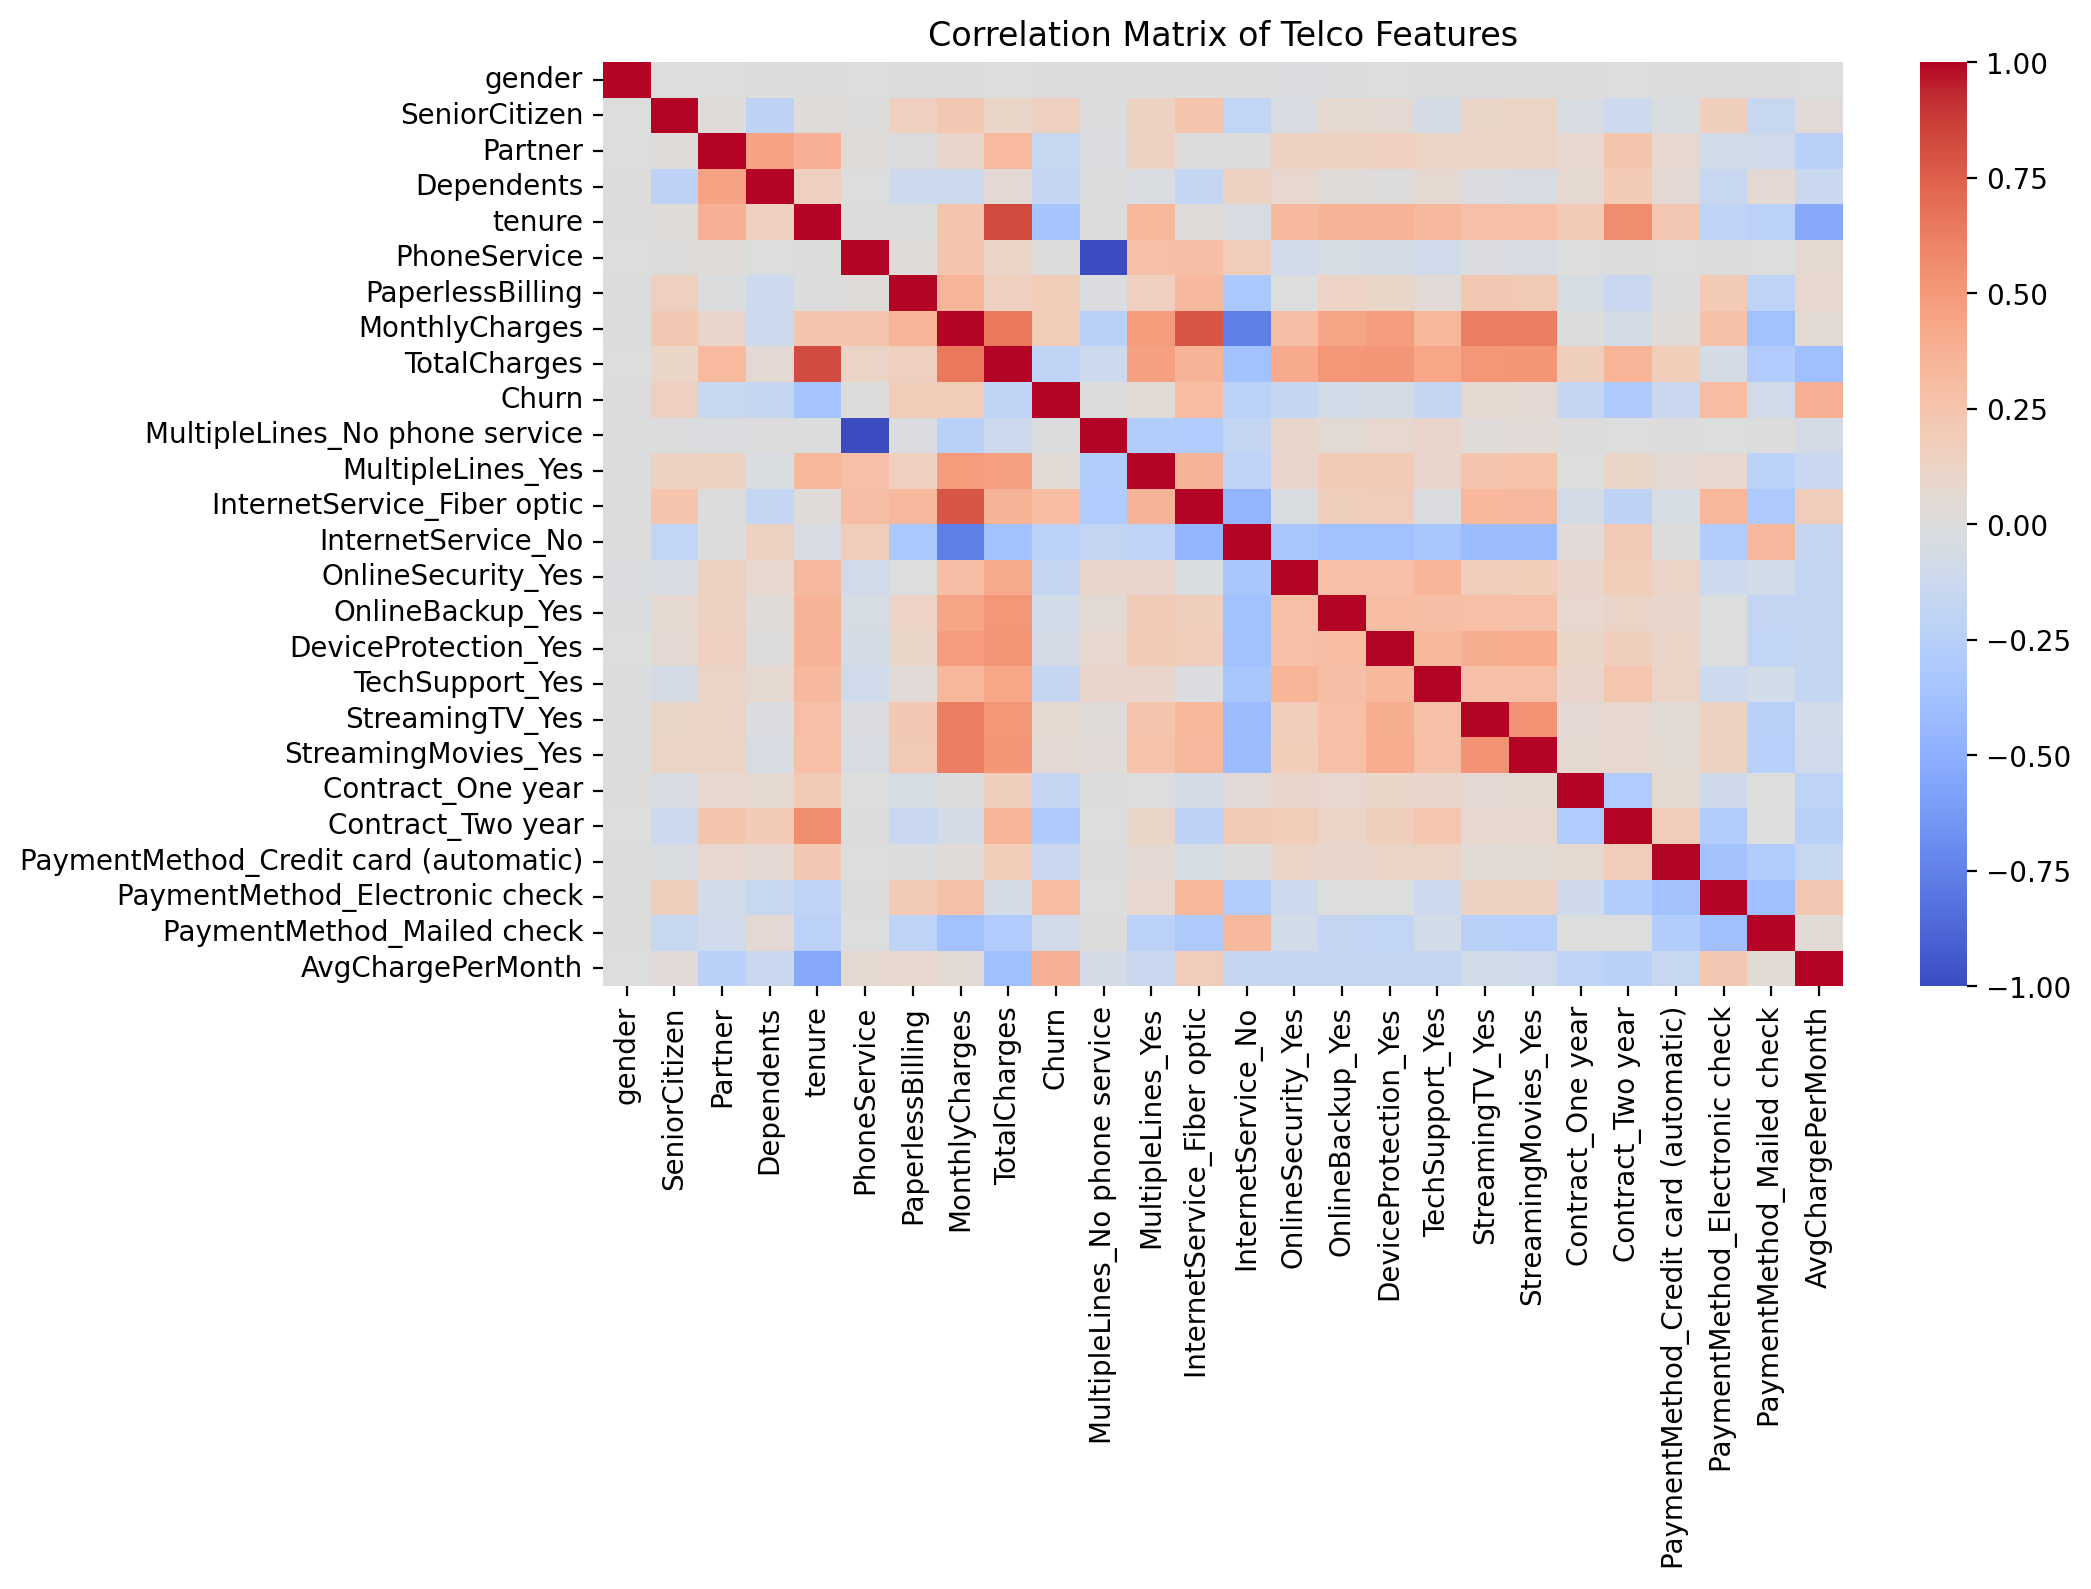

In [55]:
# Some Visualizations
features = ['Churn', 'gender', 'Partner', 'SeniorCitizen', 'Dependents', 'Contract']

# Create the grid
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
axes = axes.flatten()

for i, col in enumerate(features):
    # Determine if we need the 'hue' split (don't need it if we are plotting Churn itself)
    show_hue = 'Churn' if col != 'Churn' else None
    
    sns.countplot(data=df, x=col, hue=show_hue, palette='coolwarm', ax=axes[i])
    
    
    if col == 'Churn':
        axes[i].set_title('Overall Churn Distribution', fontsize=14)
    else:
        axes[i].set_title(f'Churn by {col} status', fontsize=14)
    
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')

# Remove the empty 6th subplot
if len(features) < len(axes):
    for j in range(len(features), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


# Churn by Tenure
plt.figure(figsize=(8, 6))
sns.histplot(data=df_final, x='tenure', hue='Churn', multiple='stack', palette='viridis', kde=True)
plt.title('Tenure Distribution by Churn')
plt.xlabel('Tenure (Months)')
plt.legend(title='Churn', labels=['Yes', 'No'])
plt.show()

# Monthly Charges distribution by Churn
plt.figure(figsize=(8, 6))
sns.kdeplot(data=df_final, x='MonthlyCharges', hue='Churn',fill=True)
plt.title('Monthly Charges by Churn')
plt.xlabel('Monthly Charges')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# Calculate the correlation matrix
corr_matrix = df_final.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title("Correlation Matrix of Telco Features")
plt.show()

In [56]:
pip install imblearn


[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Before SMOTE:  Churn
0    4138
1    1496
Name: count, dtype: int64
After SMOTE:  Churn
0    4138
1    4138
Name: count, dtype: int64
MODEL PERFORMANCE
ROC AUC Score: 0.8352

Confusion Matrix:
[[821 215]
 [110 263]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.79      0.83      1036
           1       0.55      0.71      0.62       373

    accuracy                           0.77      1409
   macro avg       0.72      0.75      0.73      1409
weighted avg       0.79      0.77      0.78      1409



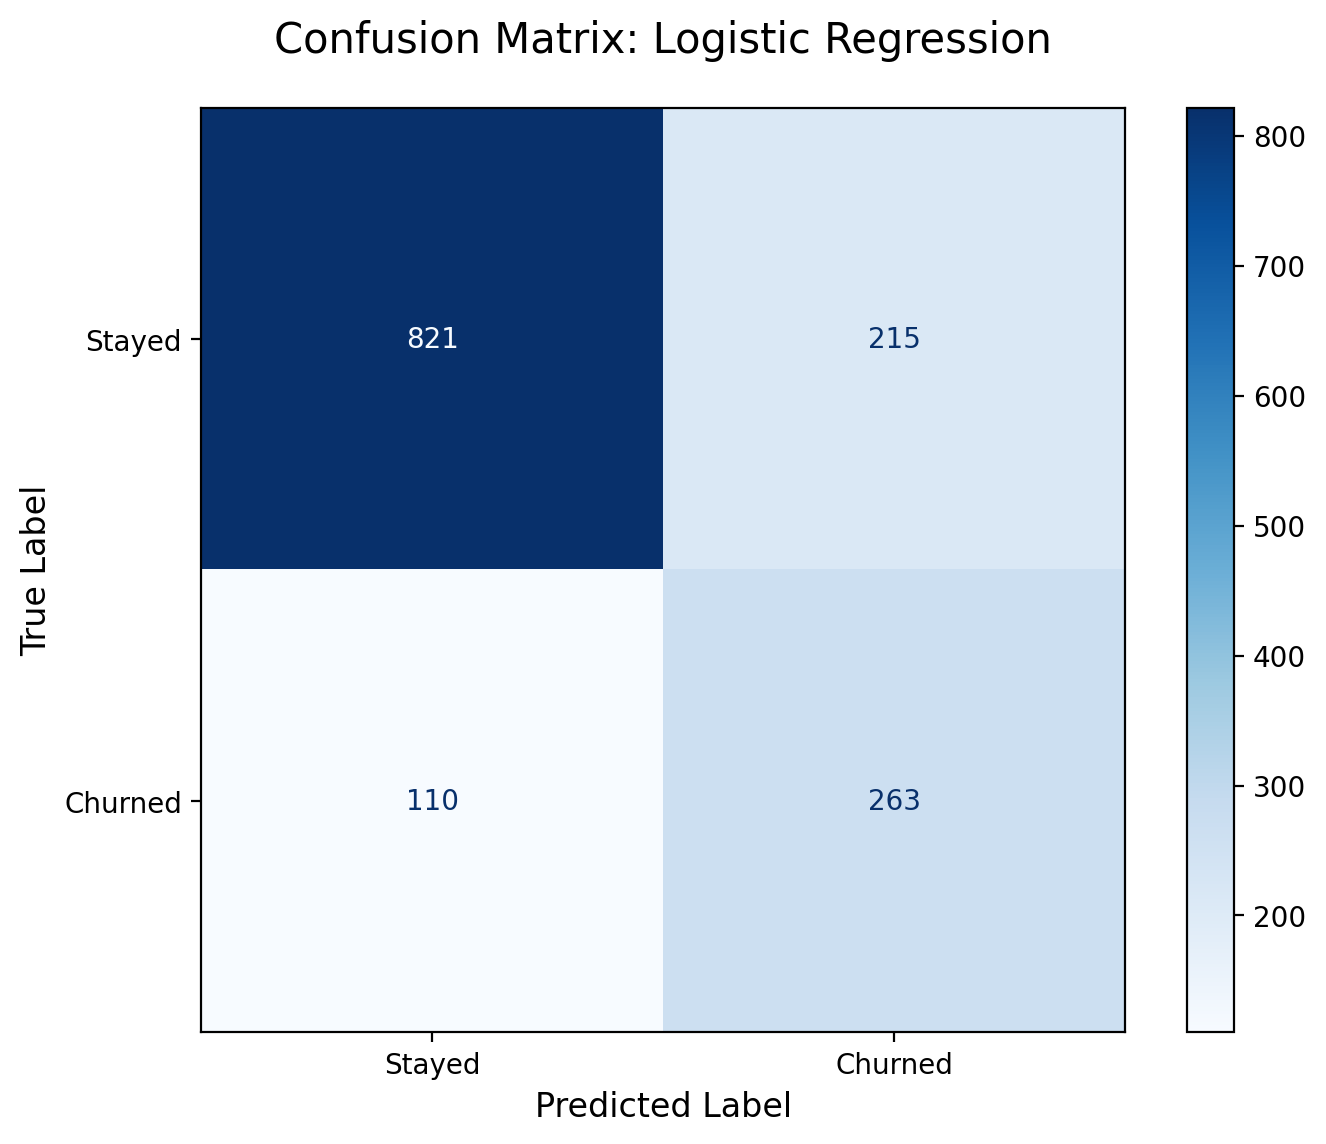

In [57]:
# 3. Modelling

from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from matplotlib import style

# Select Features and Target
X = df_final.drop(['Churn'], axis=1)
y = df_final['Churn']

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE only on training data
smote = SMOTE(random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Verify
print("Before SMOTE: ", y_train.value_counts())

print("After SMOTE: ", y_train_smote.value_counts())


# Build pipeline and initiate StandardScaler and LogisticRegression
pipeline = Pipeline([
    ("scaler", StandardScaler ()),
    ("logreg", LogisticRegression(max_iter=1000))
])


# Fit the Logistic Regression model
pipeline.fit(X_train_smote, y_train_smote)
y_pred = pipeline.predict(X_test)
y_pred_probs= pipeline.predict_proba(X_test)[:, 1]


# Model evaluation
print("MODEL PERFORMANCE")
# Compute ROC AUC
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_probs):.4f}")
print("\nConfusion Matrix:")
# Print the confusion matrix
print(confusion_matrix(y_test, y_pred))
# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Visualize the confusion matrix
plt.style.use('default')
fig, ax = plt.subplots(figsize=(8,6))
disp =ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=['Stayed', 'Churned'],
    cmap='Blues',
    values_format='d',
    ax=ax
)

plt.title('Confusion Matrix: Logistic Regression', fontsize=15, pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.grid(False)
plt.show()

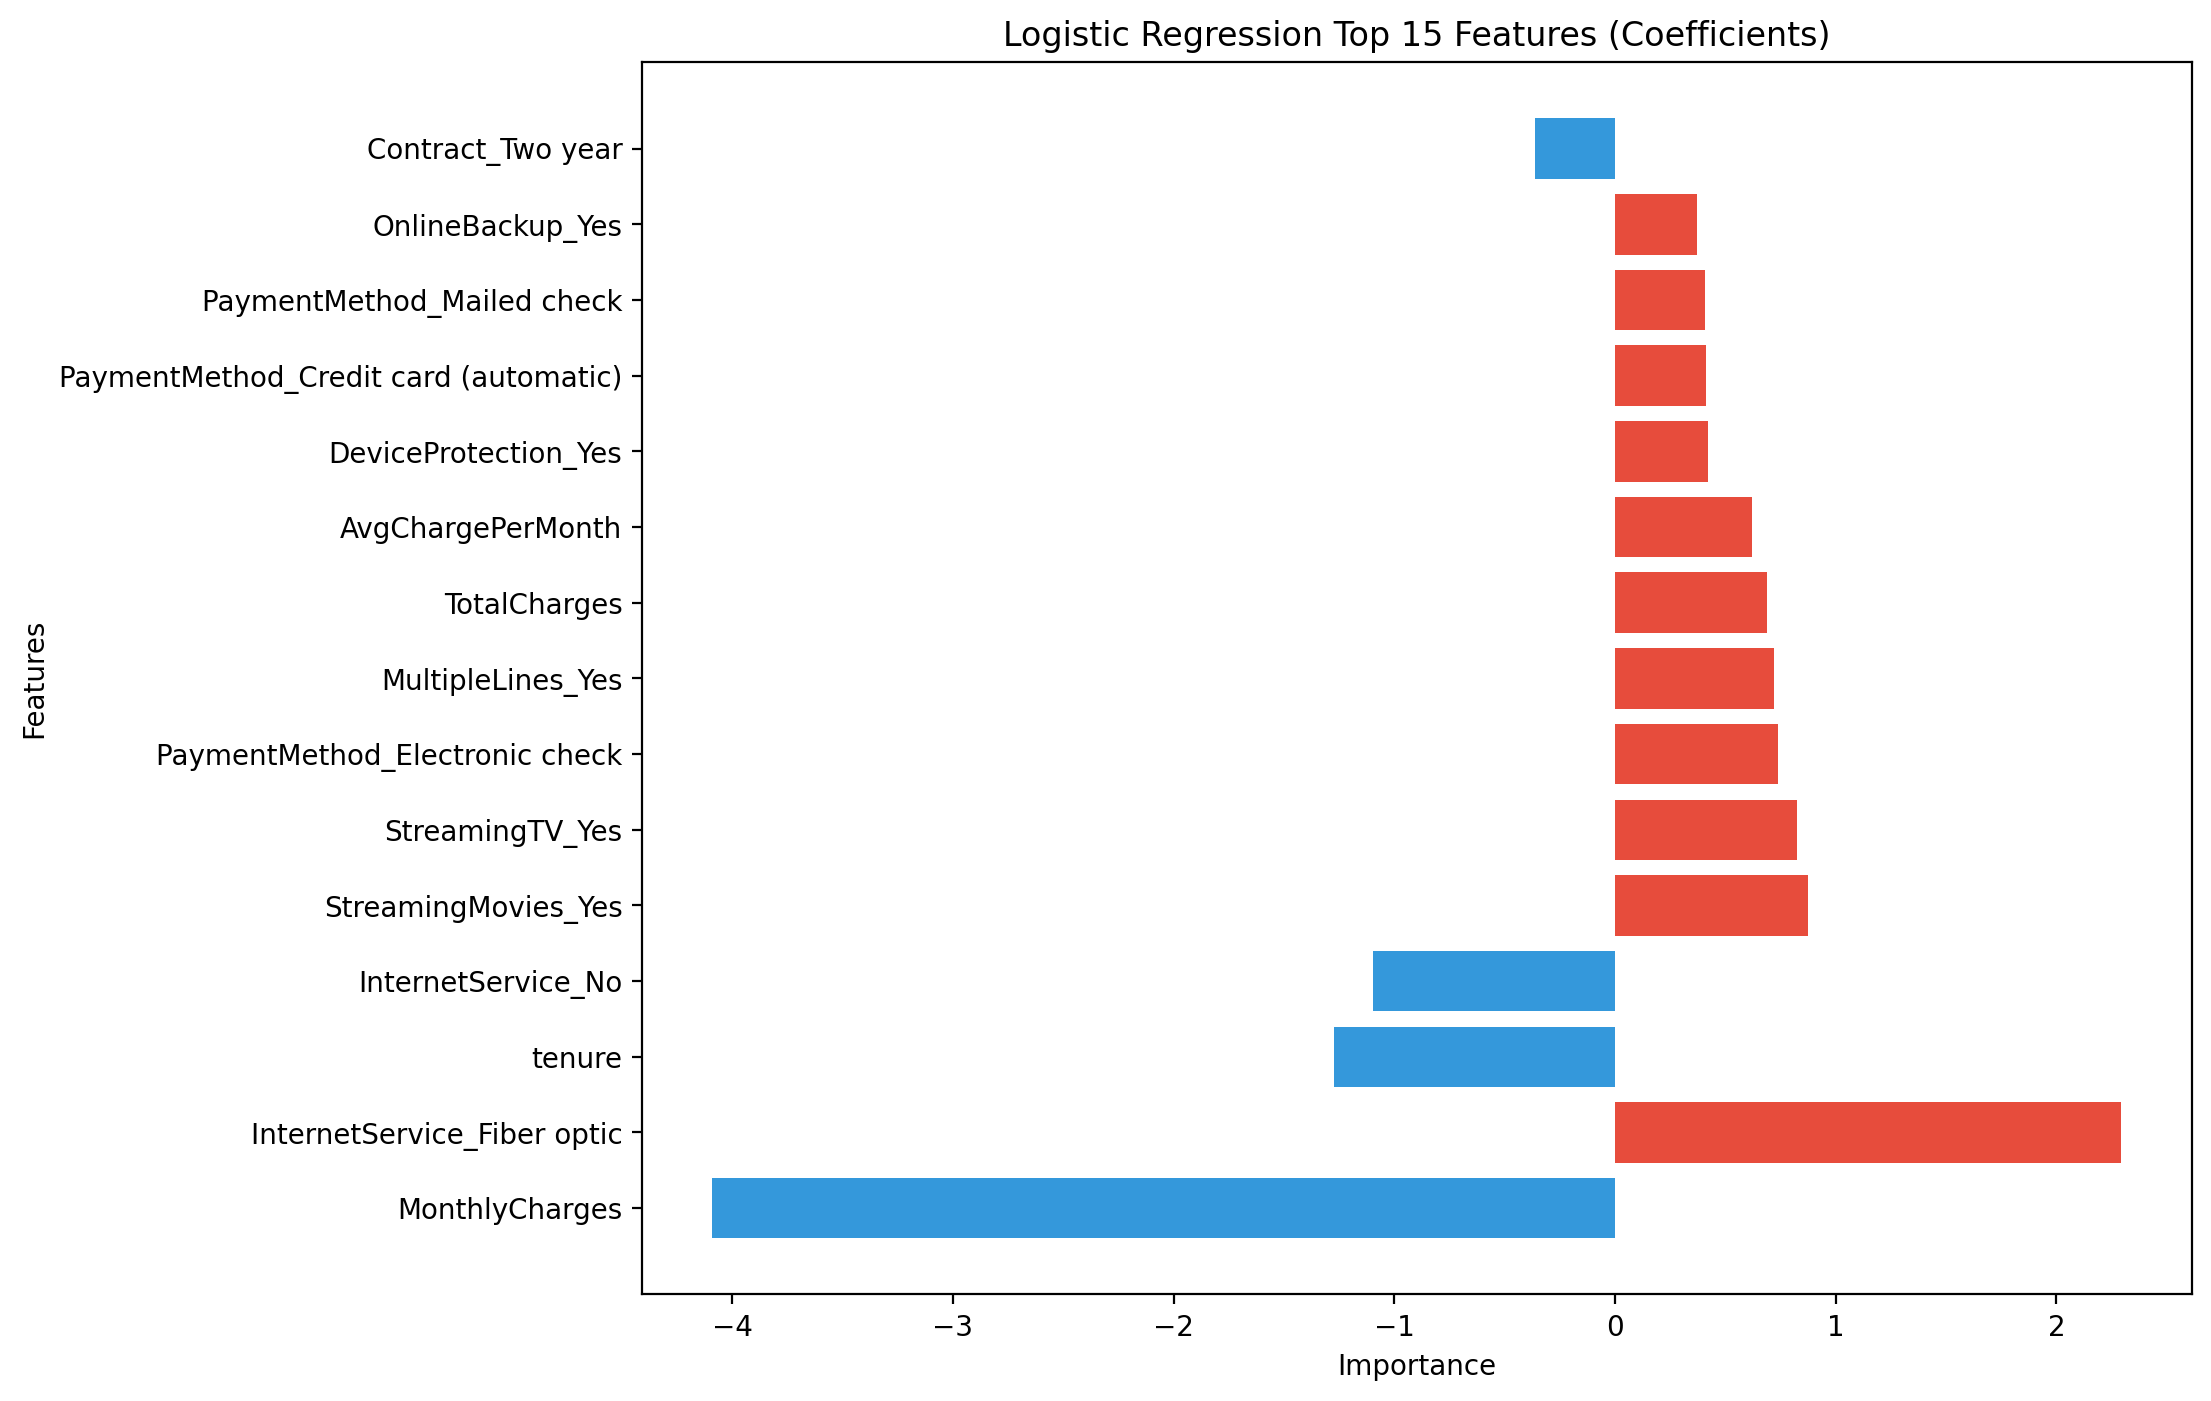

In [58]:
# Feature Importance: Logistic Regression

# Access model in pipeline
logreg_model = pipeline.named_steps['logreg']
feature_names= X_train_smote.columns

# Create DataFrame
lr_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': logreg_model.coef_[0]
})

lr_importance['Abs_Importance'] = lr_importance['Importance'].abs()
lr_importance = lr_importance.sort_values(by='Abs_Importance', ascending=False)

# Visualize
plt.figure(figsize=(10, 8))
# Red for positive influence on Churn, Blue for negative
colors = ['#e74c3c' if x > 0 else '#3498db' for x in lr_importance['Importance'][:15]]
plt.barh(lr_importance['Feature'][:15], lr_importance['Importance'][:15], color=colors)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Logistic Regression Top 15 Features (Coefficients)')
plt.show()

MODEL PERFORMANCE
ROC AUC Score: 0.8259
[[880 156]
 [160 213]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1036
           1       0.58      0.57      0.57       373

    accuracy                           0.78      1409
   macro avg       0.71      0.71      0.71      1409
weighted avg       0.77      0.78      0.78      1409



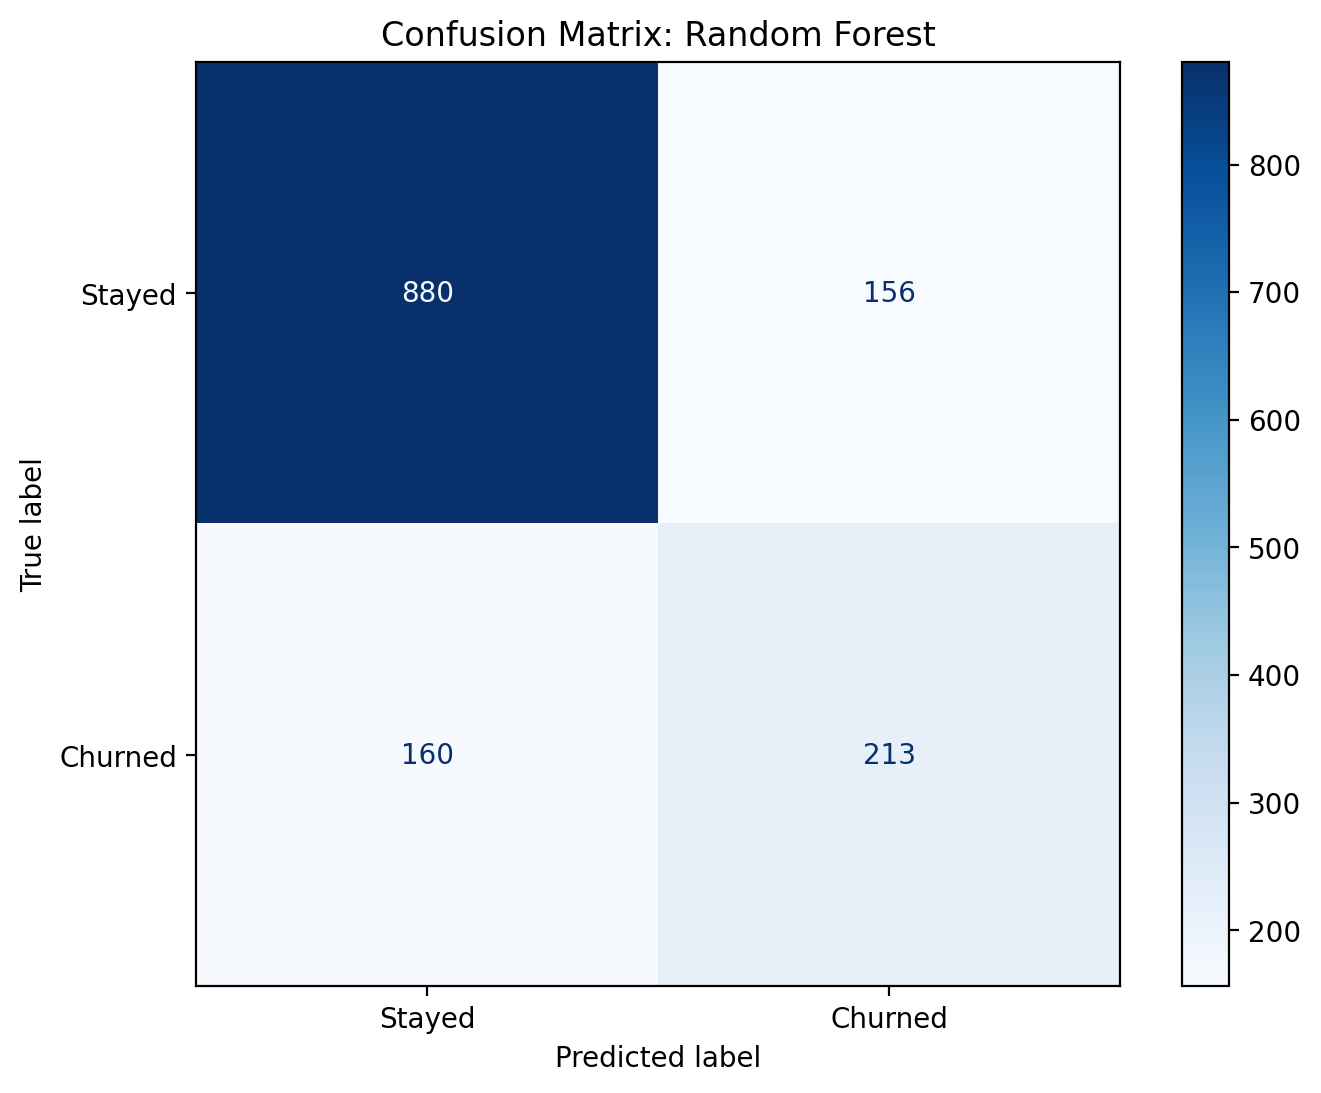

In [59]:
# Train a Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_smote, y_train_smote)

# Predictions
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

# Compute ROC AUC
print("MODEL PERFORMANCE")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob_rf):.4f}")
# Print the confusion matrix
print(confusion_matrix(y_test, y_pred_rf))
# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

# Visualize the confusion matrix
plt.style.use('default') 
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay.from_estimator(
    rf_model, 
    X_test, 
    y_test, 
    display_labels=['Stayed', 'Churned'], 
    cmap='Blues',
    values_format='d',
    ax=ax
)
plt.title("Confusion Matrix: Random Forest")
plt.grid(False)
plt.show()

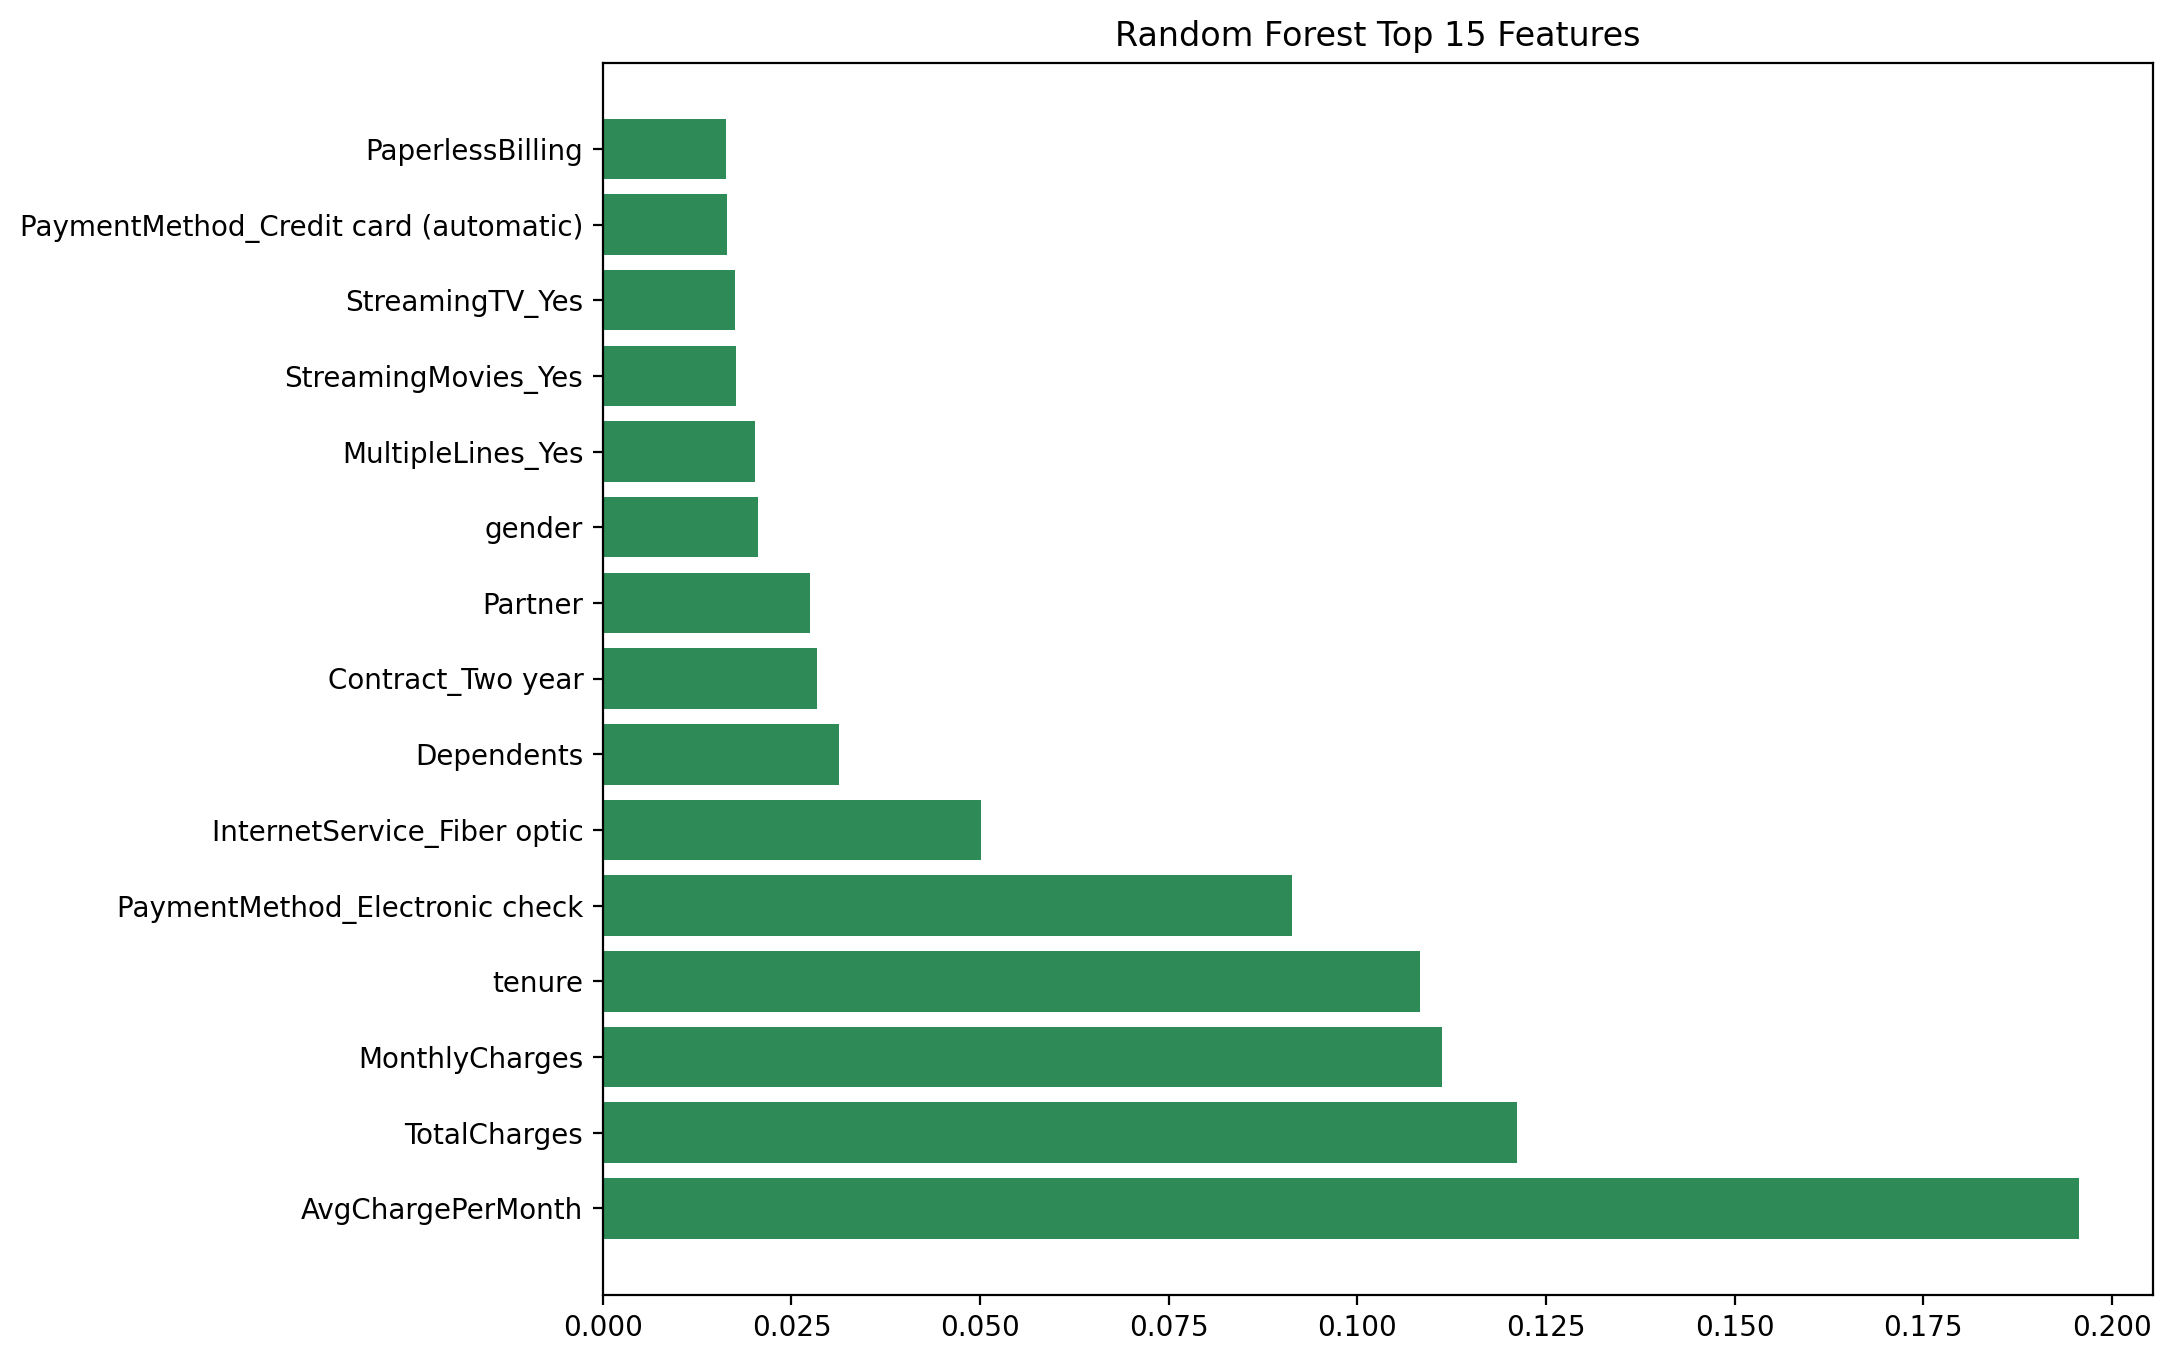

In [60]:
# Feature Importance RandomForest

rf_importance = pd.DataFrame({
    'Feature': X_train_smote.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Visualize
plt.figure(figsize=(10, 8))
plt.barh(rf_importance['Feature'][:15], rf_importance['Importance'][:15], color='seagreen')
plt.title('Random Forest Top 15 Features')
plt.show()

Best parameters: {'logreg__C': 10}
Test accuracy: 77.00%
[[824 212]
 [112 261]]


              precision    recall  f1-score   support

           0       0.88      0.80      0.84      1036
           1       0.55      0.70      0.62       373

    accuracy                           0.77      1409
   macro avg       0.72      0.75      0.73      1409
weighted avg       0.79      0.77      0.78      1409



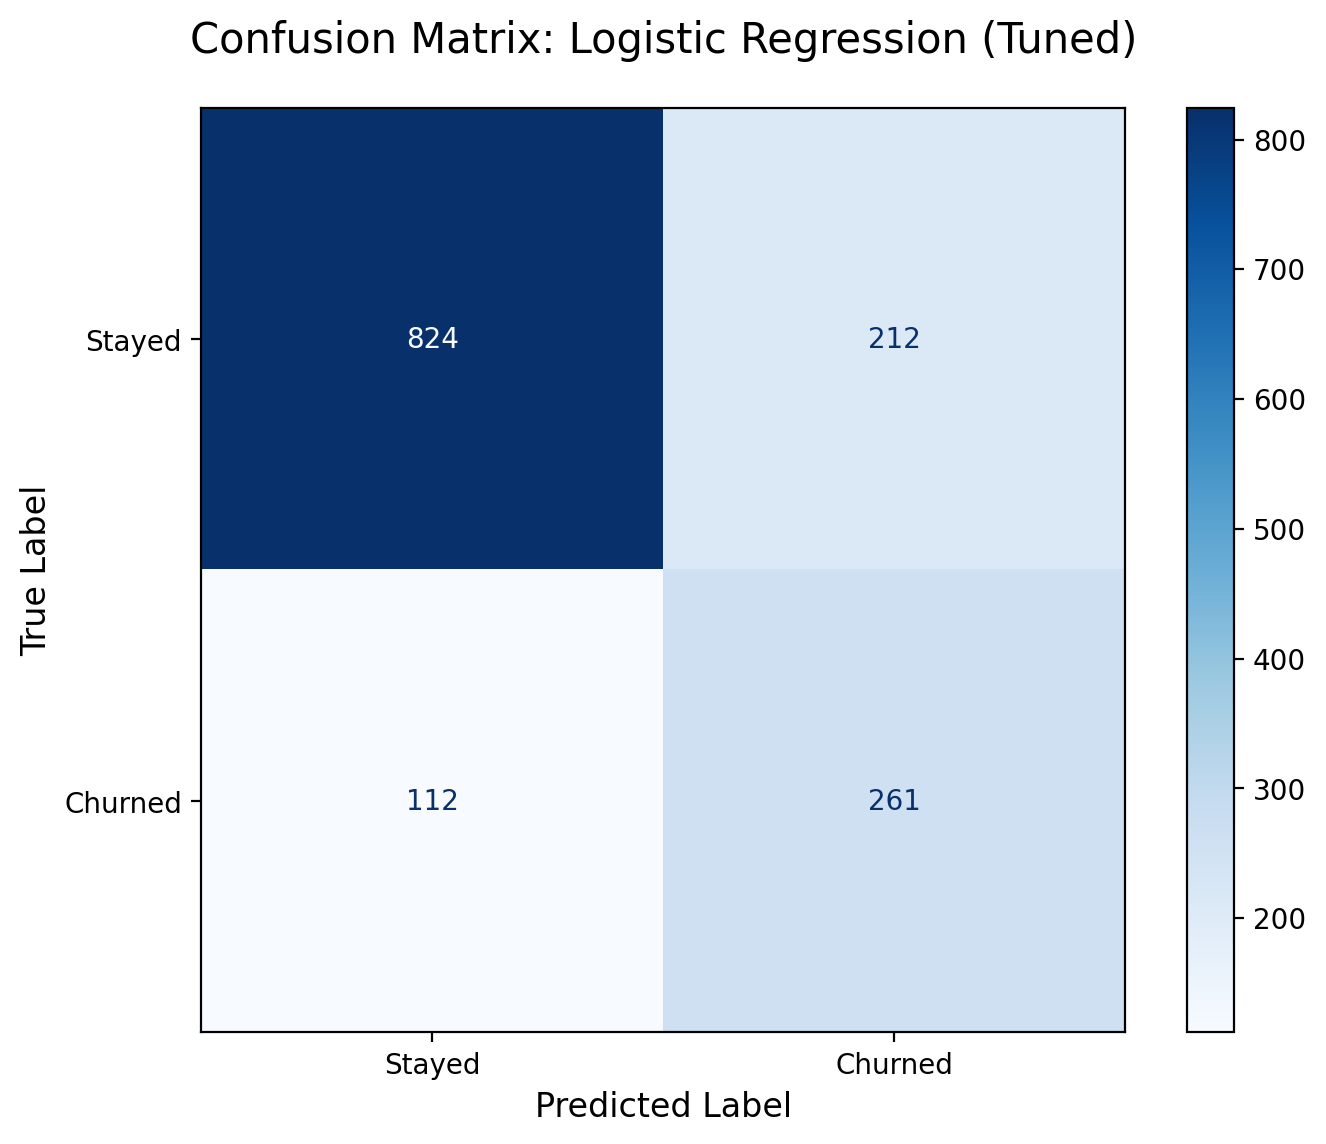

In [61]:
# Tune up models with hyperparameter tuning
# Logistic Regression model

# import GridSearchCV
from sklearn.model_selection import GridSearchCV

param_grid={'logreg__C':[0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(pipeline, param_grid)
grid.fit(X_train_smote, y_train_smote)


GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10]})


# Print best parameter
print("Best parameters:", grid.best_params_)

y_pred = grid.predict(X_test)


# Get and print accuracy score
logreg_acc = accuracy_score(y_pred, y_test)
print("Test accuracy: {:.2f}%".format(logreg_acc*100))


# Print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print("\n")
print(classification_report(y_test, y_pred))


# Visualize the confusion matrix
plt.style.use('default') 
fig, ax = plt.subplots(figsize=(8, 6))

disp = ConfusionMatrixDisplay.from_predictions(
    y_test, 
    y_pred, 
    display_labels=['Stayed', 'Churned'],
    cmap='Blues',                         
    ax=ax              
)

plt.title('Confusion Matrix: Logistic Regression (Tuned)', fontsize=15, pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.grid(False)
plt.show()



Best RF Parameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 20, 'class_weight': 'balanced_subsample'}
Best Cross-Val AUC: 0.8387
Test accuracy: 77.86%
[[872 164]
 [148 225]]


              precision    recall  f1-score   support

           0       0.85      0.84      0.85      1036
           1       0.58      0.60      0.59       373

    accuracy                           0.78      1409
   macro avg       0.72      0.72      0.72      1409
weighted avg       0.78      0.78      0.78      1409



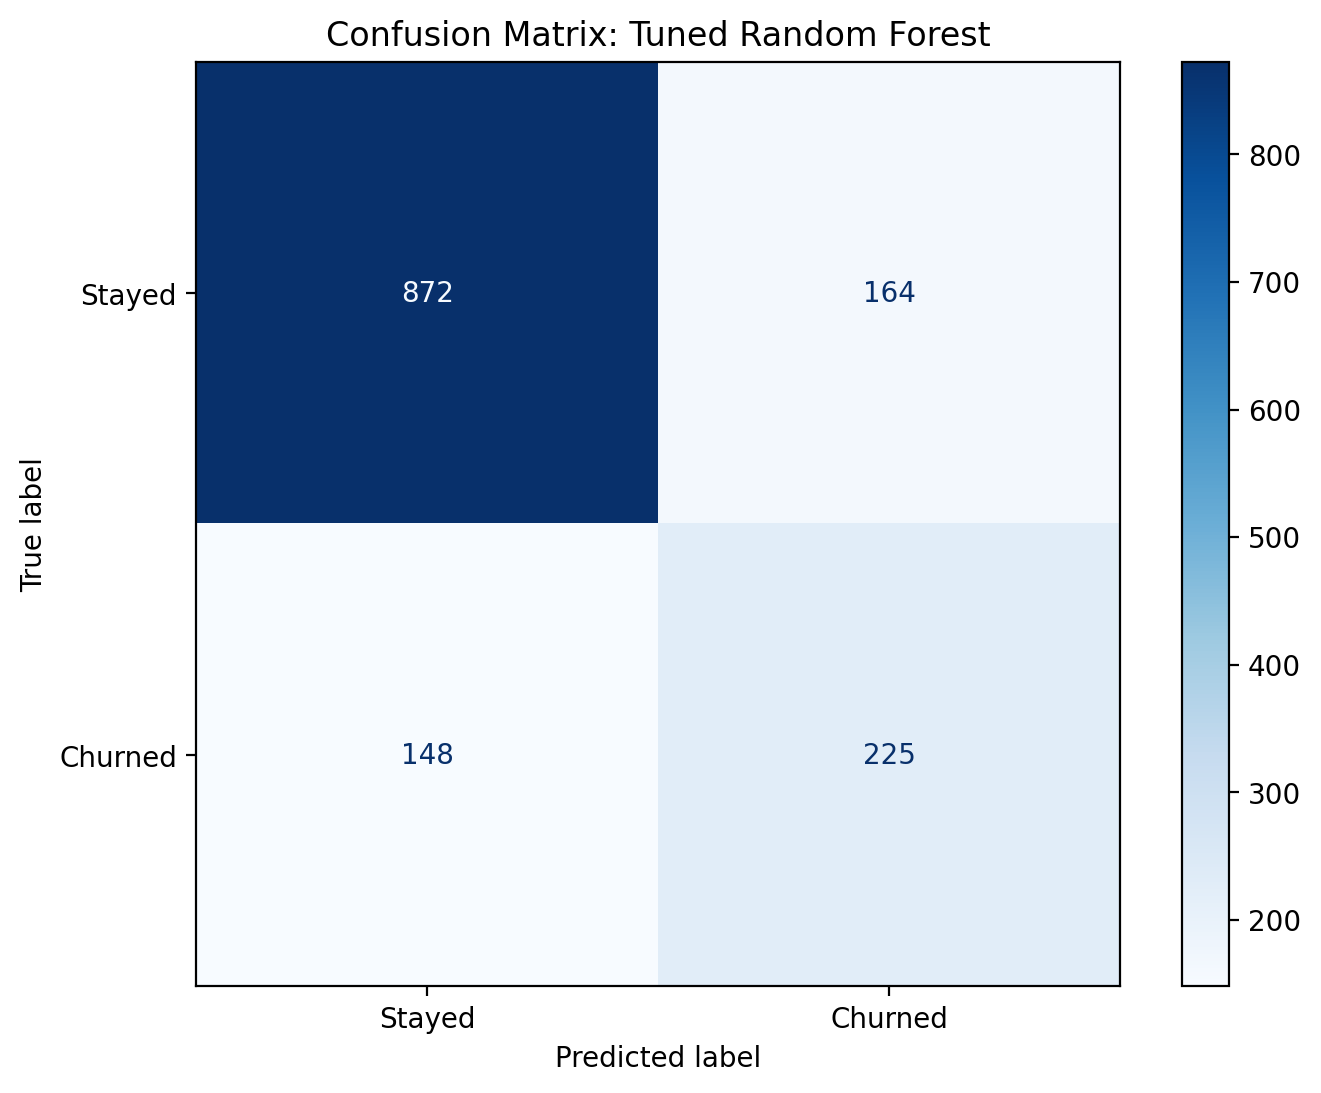

In [62]:
# import RandomizedSearchCV

from sklearn.model_selection import RandomizedSearchCV

# Create the parameter space
rf_params = {
    "n_estimators": [100, 200, 300],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "class_weight": ["balanced", "balanced_subsample", None]
         }

# Instantiate the RandomizedSearchCV object
rf_model_cv = RandomizedSearchCV(estimator=rf_model, 
    param_distributions=rf_params, 
    n_iter=10,        
    random_state=42, 
    n_jobs=-1)

# Fit the data to the model
rf_model_cv.fit(X_train_smote, y_train_smote)

# Print the tuned parameters and score
print("\nBest RF Parameters:", rf_model_cv.best_params_)
print(f"Best Cross-Val AUC: {rf_model_cv.best_score_:.4f}")

y_pred = rf_model_cv.predict(X_test)

# Get and print accuracy score
rf_model_acc = accuracy_score(y_pred, y_test)
print("Test accuracy: {:.2f}%".format(rf_model_acc*100))


# Print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print("\n")
print(classification_report(y_test, y_pred))


# Visualize the confusion matrix
plt.style.use('default') 
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay.from_estimator(
    rf_model_cv, 
    X_test, 
    y_test, 
    display_labels=['Stayed', 'Churned'], 
    cmap='Blues',
    values_format='d',
    ax=ax
)
plt.title("Confusion Matrix: Tuned Random Forest")
plt.grid(False)
plt.show()

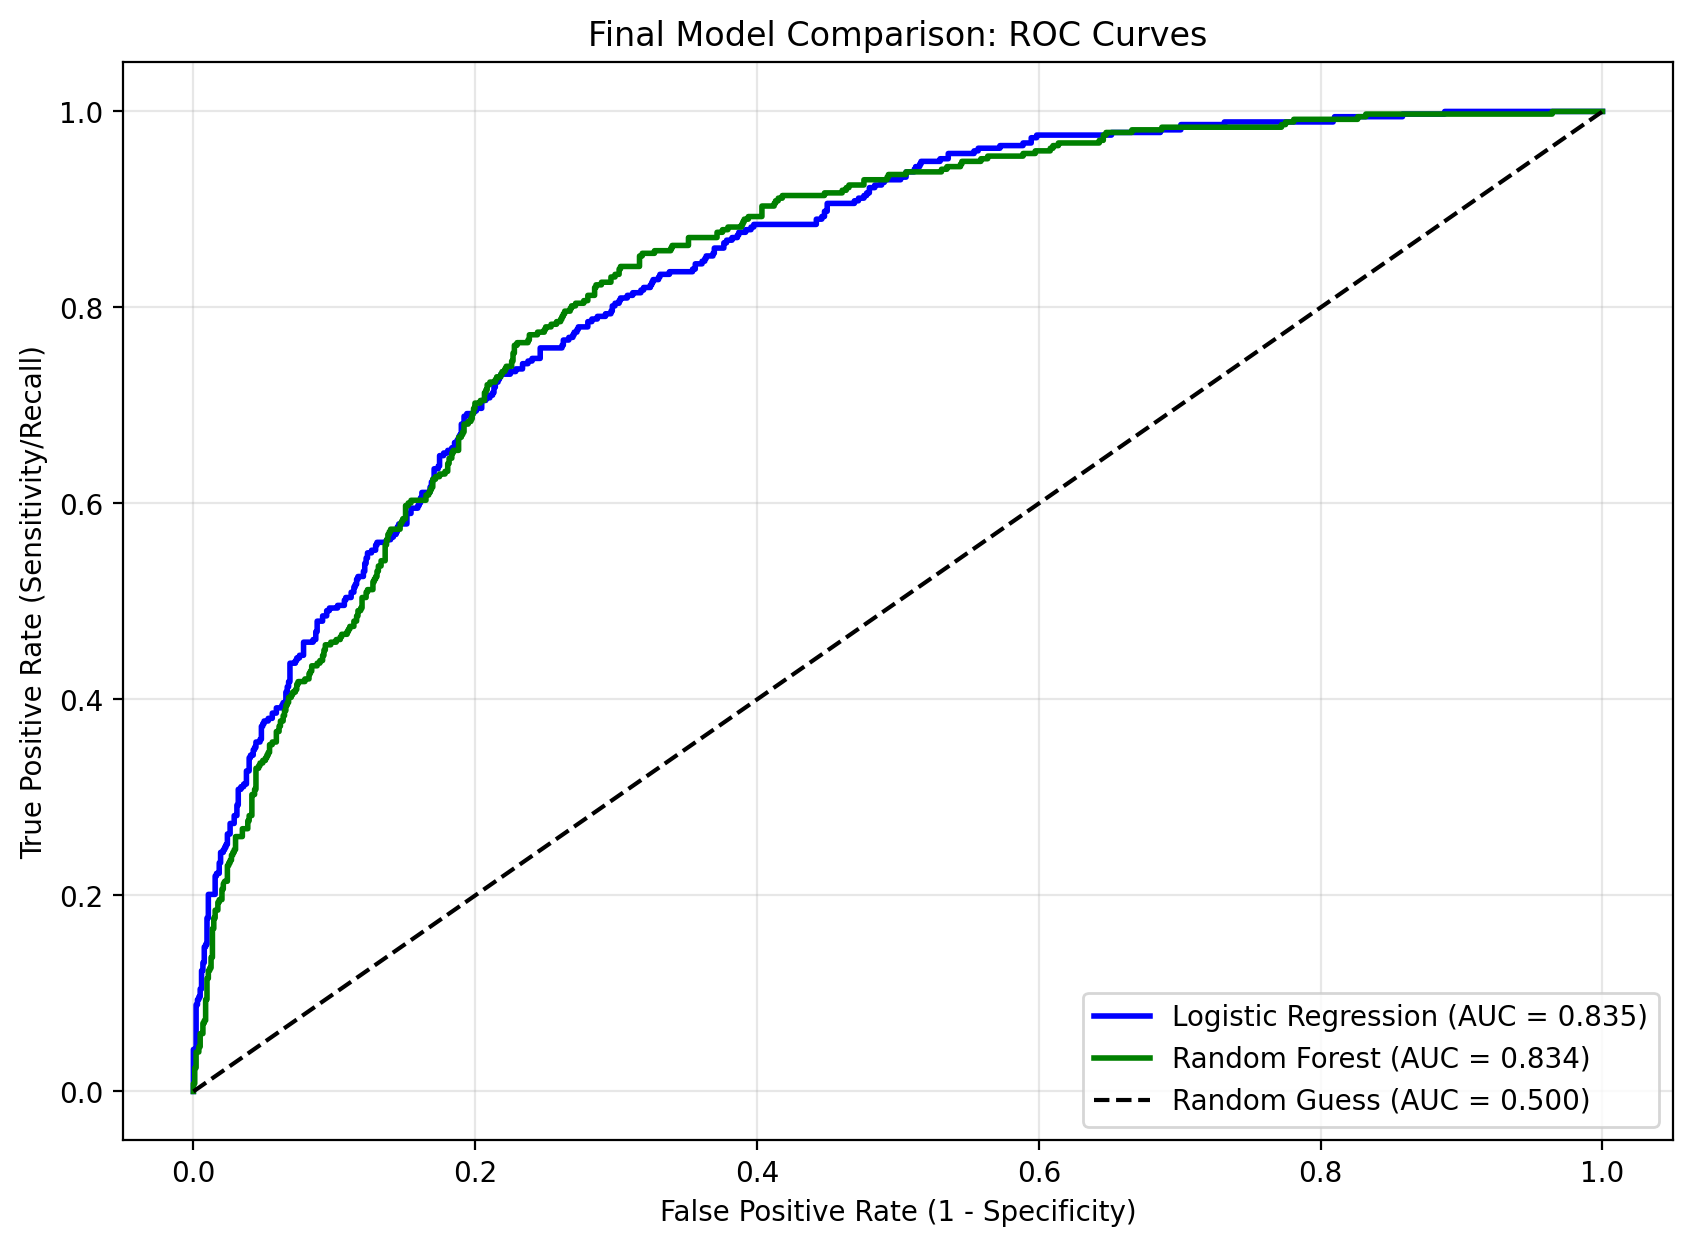

In [63]:
# Visuale The ROC Curve

# Get predicted probabilities for the positive class (Churn)
y_prob_lr = grid.predict_proba(X_test)[:, 1]
y_prob_rf = rf_model_cv.predict_proba(X_test)[:, 1]

# Compute ROC curve values
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

# Plotting
plt.figure(figsize=(10, 7))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, y_prob_lr):.3f})', color='blue', lw=2)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_prob_rf):.3f})', color='green', lw=2)

# Plot the "Random Guess" line
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess (AUC = 0.500)')

plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity/Recall)')
plt.title('Final Model Comparison: ROC Curves')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

In [64]:
pip install shap


[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


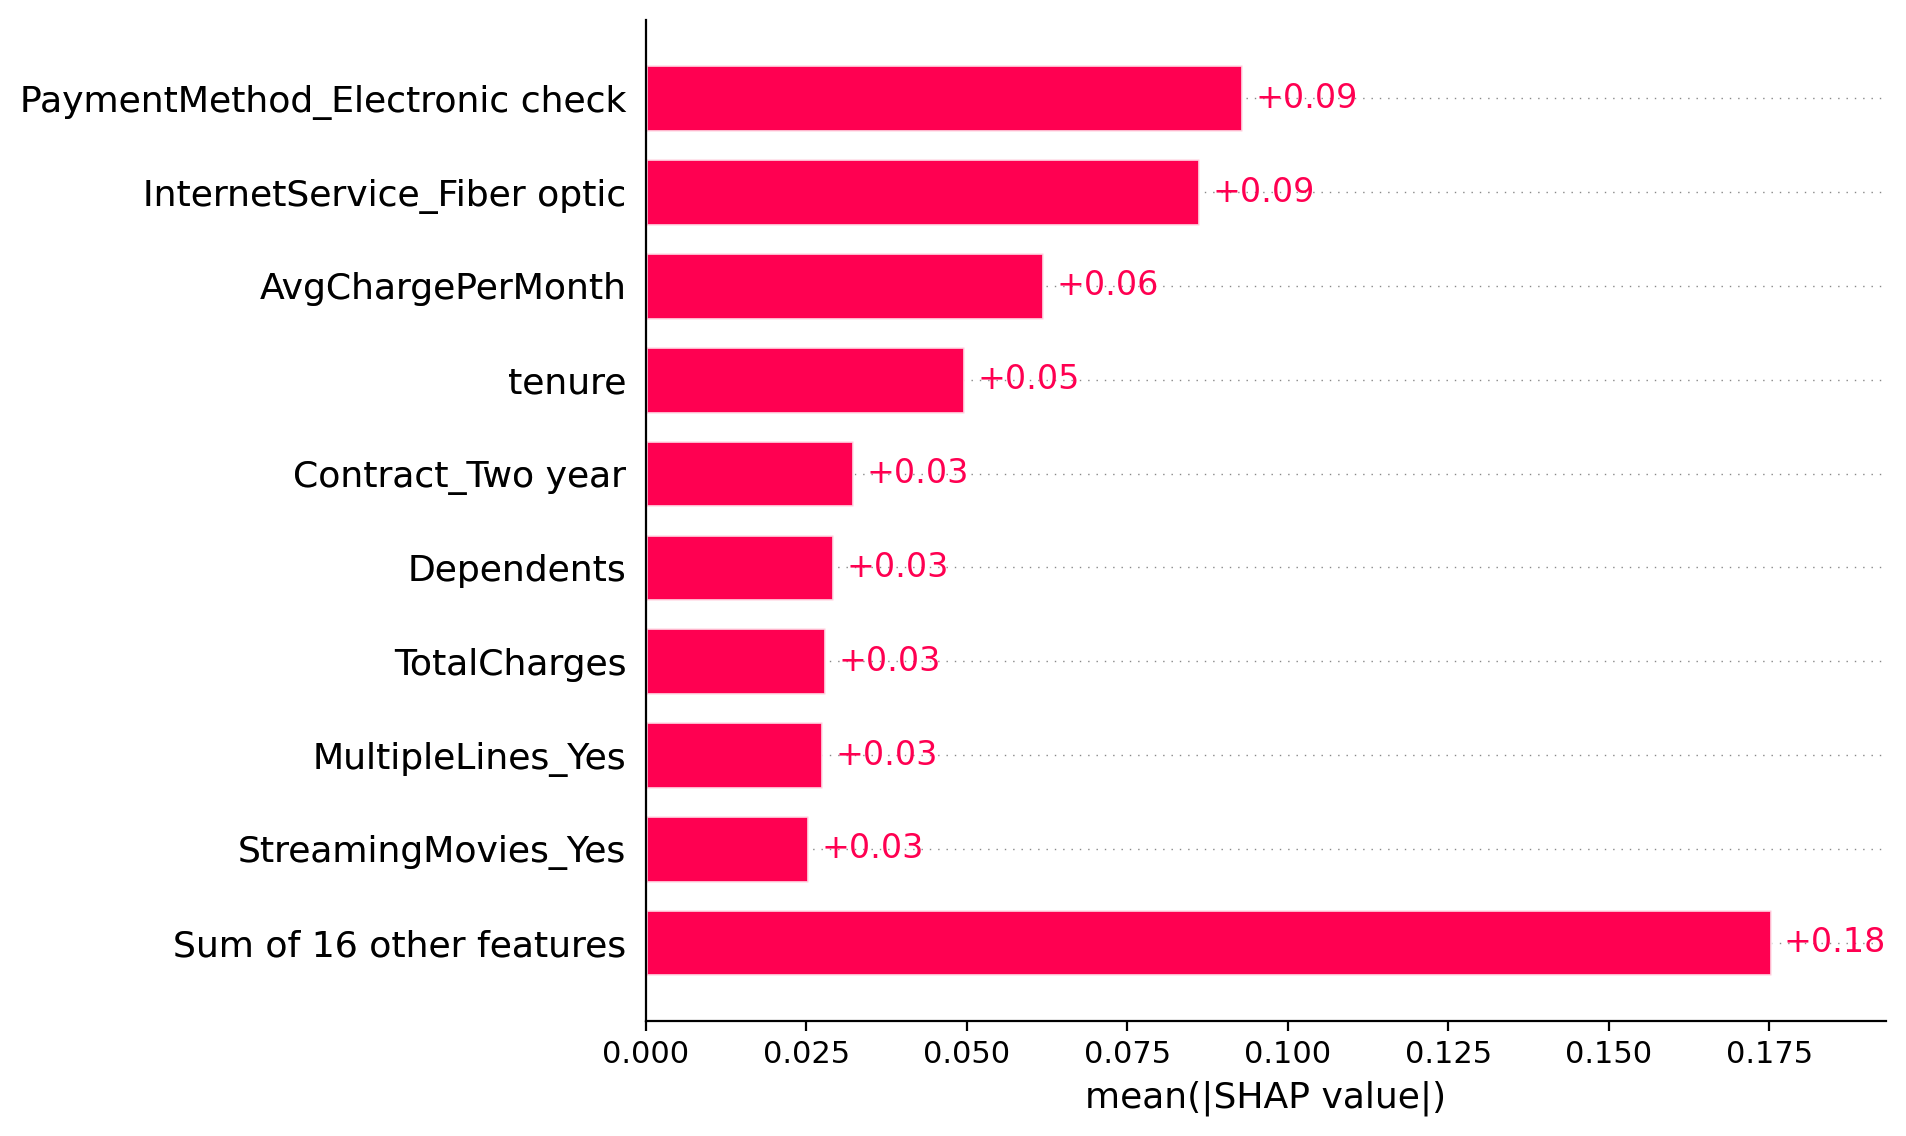

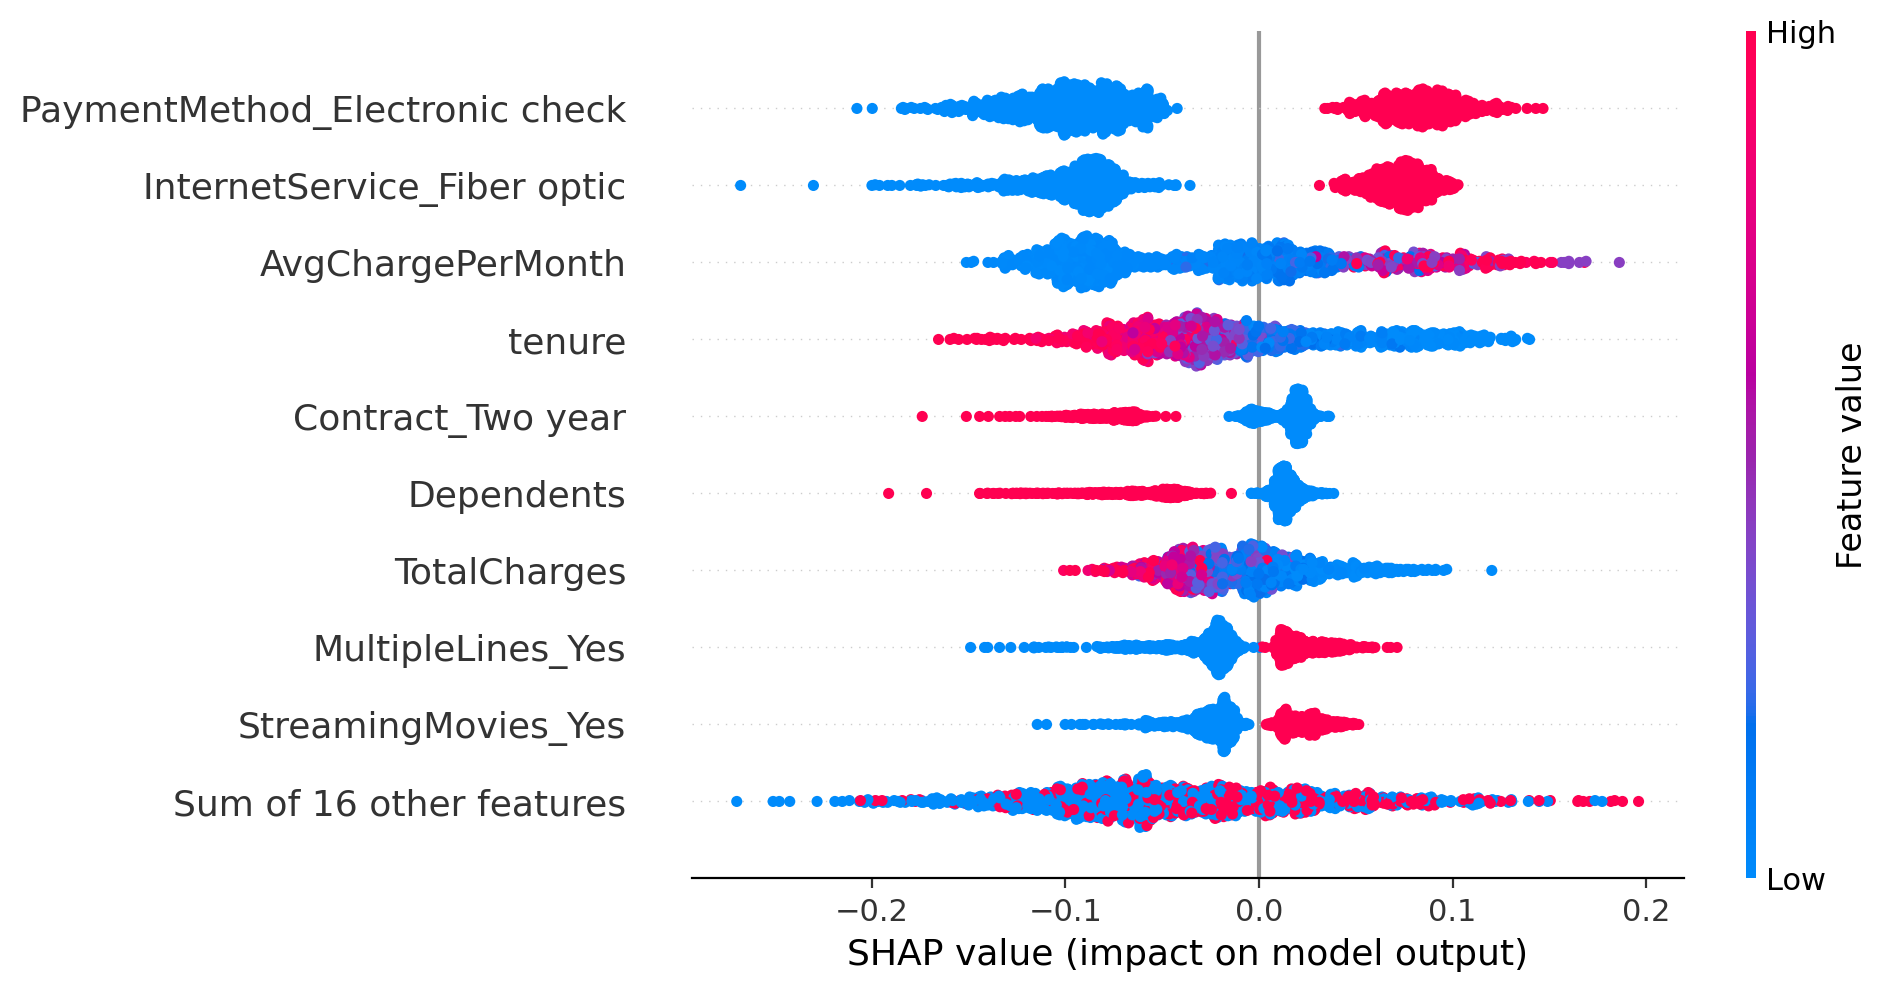

In [71]:
# Explain Individual Contributions with SHAP (Shapley Additive Explanations)

import shap

# Ensure numeric data
X_test_numeric = X_test.astype(float)

# Initiate Explainer
explainer = shap.TreeExplainer(rf_model_cv.best_estimator_)

# Calculate SHAP values
shap_values = explainer(X_test_numeric)

# Visualize
# Use the [:, :, 1] index to get the values for the 'Churn' class
plt.figure(figsize=(10, 6))
shap.plots.bar(shap_values[:, :, 1])

plt.figure(figsize=(10, 6))
shap.plots.beeswarm(shap_values[:, :, 1])